<a href="https://colab.research.google.com/github/Yanina-Kutovaya/RecSys-amazon/blob/main/notebooks/01_Build_dataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender system Amazon - Grocery and Gourmet Food

## Build dataset, EDA

[Data source](https://nijianmo.github.io/amazon/index.html)

In [1]:
!git clone https://github.com/Yanina-Kutovaya/RecSys-amazon.git

Cloning into 'RecSys-amazon'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 65 (delta 23), reused 53 (delta 15), pack-reused 0
Unpacking objects: 100% (65/65), 65.51 KiB | 1.04 MiB/s, done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget -q -P /content/RecSys-amazon/data/01_raw https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food.csv --no-check-certificate
!wget -q -P /content/RecSys-amazon/data/01_raw https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz --no-check-certificate
!cp /content/drive/MyDrive/OTUS_ML_advanced/06_RecSys/amazon/meta_Grocery_and_Gourmet_Food.json.gz /content/RecSys-amazon/data/01_raw/

In [4]:
%cd RecSys-amazon

/content/RecSys-amazon


In [5]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "recsys_amazon"))

In [6]:
import pandas as pd
import gzip
import re
import json
import matplotlib.pyplot as plt

from data.make_dataset import (
    load_ratings, 
    select_users_item_pairs, 
    add_user_reviews_to_ratings
)
from data.train_validation_split import time_split
from data.item_data import get_items_matadata 
from data.user_data import get_user_reviews

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
PATH = "data/01_raw/"
DATA_PATH = PATH + "Grocery_and_Gourmet_Food.csv"
ITEM_FEATURES_PATH = PATH + "meta_Grocery_and_Gourmet_Food.json.gz"
USER_FEATURES_PATH = PATH + "Grocery_and_Gourmet_Food_5.json.gz"

## 1. Build dataset

### 1.1. Ratings data

In [9]:
data = load_ratings(DATA_PATH)

print(f'ratings.shape = {data.shape}\n')
data.head(2)

ratings.shape = (5074160, 4)



,item_id,user_id,rating,timestamp
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200


#### 1.1.1. Collected data time period

In [10]:
n_years = (
    data['timestamp'].max() - data['timestamp'].min()
) / 3600 / 24 // 365
print(f'Data is collected for {int(n_years)} years')

Data is collected for 18 years


#### 1.1.2. Select users-item pairs

Selects users who rated at least 3 items and items rated by at least 2 useres

In [11]:
user_ids, item_ids = select_users_item_pairs(data)
len(user_ids), len(item_ids )

(4372, 6632)

### 1.2. Train-validation-test time split for two-stage recommender system.

    Train - validation - test schema:
    -- 5 years -- | -- 2 years -- | -- 1 year --

    For the 1st level model we use 5-years data for train and 2-years data for validation.
    For the 2nd level mmodel we use 2-years data for train and 1-year - for validation.
    Validation data for the 1st levl model serves as train data for the 2nd level model.

In [12]:
year = 365 * 24 * 3600
t2 = data["timestamp"].max() - year
t1 = t2 - 2 * year
t0 = t1 - 5 * year

(
    selected_users,
    selected_items,
    data_train_lvl_1,
    data_val_lvl_1,
    data_val_lvl_2,
) = time_split(t0, t1, t2, user_ids, item_ids, data)

In [13]:
len(selected_users), len(selected_items)

(2047, 2533)

In [14]:
print(f'ratings.shape = {data_train_lvl_1.shape}\n')
data_train_lvl_1.head(2)

ratings.shape = (10241, 4)



,item_id,user_id,rating,timestamp
1048,B00005BPQ9,A2XCLJRGFANRC,5.0,1425168000
1061,B00005BPQ9,AHKXYQ7TP6REK,4.0,1419206400


In [15]:
print(f'ratings.shape = {data_val_lvl_1.shape}\n')
data_val_lvl_1.head(2)

ratings.shape = (10445, 4)



,item_id,user_id,rating,timestamp
1025,B00005BPQ9,A3TH42PC3EZV1B,4.0,1445558400
1462,B00006FMLY,A8CGWGJ9OM58J,5.0,1455753600


In [16]:
print(f'ratings.shape = {data_val_lvl_2.shape}\n')
data_val_lvl_2.head(2)

ratings.shape = (2054, 4)



,item_id,user_id,rating,timestamp
7747,B0000D916Y,A1STWKVUMXNZAB,3.0,1524096000
8040,B0000D916Y,A2RI05C8BVQIWB,4.0,1513468800


### 1.3. Items matadata

In [17]:
items = get_items_matadata(selected_items, ITEM_FEATURES_PATH)

print(f'items.shape = {items.shape}\n')
items.head(3)

items.shape = (2529, 15)



,item_id,price,main_cat,category_1,category_2,brand,rank,rank_group,title,description,len_also_view,also_view,len_also_buy,also_buy,category_3
0,B00005BPQ9,0.00,Grocery,Candy & Chocolate,Candy & Chocolate Assortments,Whoppers,413552.0,Grocery & Gourmet Food,WHOPPERS Candy (Chocolate Covered Malted Milk ...,WHOPPERS Malted Milk Balls are the classic con...,2.0,"['B0016G1H8G', 'B0029JVUAE']",14.0,"['B0029JVUAE', 'B00374XTQI', 'B000IXUK2W', 'B0...",NaN
1,B00006FMLY,10.41,Amazon Home,Cooking & Baking,"Frosting, Icing & Decorations",Wilton,13984.0,Kitchen & Dining (See Top 100 in Kitchen & Din...,"Wilton Jimmies Rainbow Sprinkle Assortment, 3....",Sprinkle your treats with sweet color using th...,0.0,[],0.0,[],Sprinkles & Glitters
2,B00006FWVX,6.30,Amazon Home,Cooking & Baking,Food Coloring,Wilton,9512.0,Kitchen & Dining (See Top 100 in Kitchen & Din...,"Wilton Candy Decorating Primary Colors Set, 1 oz.",Can't find candy to match your party theme? Co...,1.0,['B0061TXUNS'],0.0,[],NaN


### 1.4. User reviews

In [18]:
user_reviews = get_user_reviews(selected_users, selected_items, t1, USER_FEATURES_PATH)

print(f'user_reviews.shape = {user_reviews.shape}\n')
user_reviews.head(2)

user_reviews.shape = (10927, 5)



,user_id,item_id,timestamp,text,len_text
0,A3TH42PC3EZV1B,B00005BPQ9,1445558400,"Delicious, and a good value... What more is to...",55
1,A8CGWGJ9OM58J,B00006FMLY,1455753600,great for decorating.,21


In [19]:
data_val_lvl_1, data_val_lvl_2 = add_user_reviews_to_ratings(data_val_lvl_1, data_val_lvl_2, user_reviews)

print(f'data_val_lvl_1.shape = {data_val_lvl_1.shape}\n')
data_val_lvl_1.head(2)

data_val_lvl_1.shape = (16290, 6)



,item_id,user_id,rating,timestamp,text,len_text
0,B00005BPQ9,A3TH42PC3EZV1B,4.0,1445558400,"Delicious, and a good value... What more is to...",55
1,B00006FMLY,A8CGWGJ9OM58J,5.0,1455753600,great for decorating.,21


In [20]:
print(f'data_val_lvl_2.shape = {data_val_lvl_2.shape}\n')
data_val_lvl_2.head(2)

data_val_lvl_2.shape = (1847, 6)



,item_id,user_id,rating,timestamp,text,len_text
0,B0000D916Y,A1STWKVUMXNZAB,3.0,1524096000,good,4
1,B0000D9169,A1STWKVUMXNZAB,3.0,1524096000,good,4


## 2. EDA

EDA of train and validation dataset for 2nd level model

### 2.1. Top popular items

In [21]:
data = pd.concat([data_val_lvl_1, data_val_lvl_2], axis=0)

In [22]:
popularity = (data.groupby('item_id')['user_id'].nunique() / data['user_id'].nunique()).reset_index()
popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
popularity['share_unique_users'].max()

0.06459054209919261

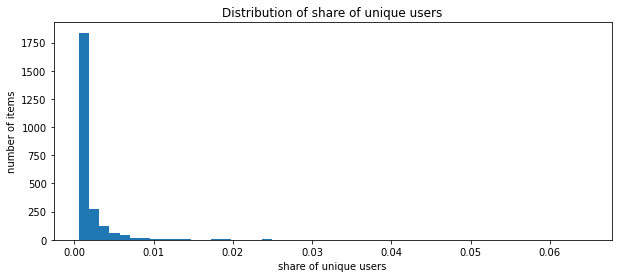

In [23]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of share of unique users')
plt.xlabel('share of unique users')
plt.ylabel('number of items')
plt.hist(popularity['share_unique_users'].values, bins=50);

### 2.2. Top unpopular items

In [24]:
top_unpopular = popularity[popularity['share_unique_users'] < 5.8e-04].item_id.tolist()
len(top_unpopular)

1157

### 2.3. Items of unpopular categories

In [25]:
main_cat_size = (
    items.groupby('main_cat')['item_id'].nunique().sort_values(ascending=False)
).reset_index()
main_cat_size.columns = ['main_cat', 'n_items']

unpopular_main_cats = main_cat_size[main_cat_size['n_items'] < 150].main_cat.tolist()
items_in_unpopular_main_cats = items[items['main_cat'].isin(unpopular_main_cats)].item_id.unique().tolist()
len(items_in_unpopular_main_cats)

125

### 2.4. Price threshold

In [26]:
data = data.merge(items[['item_id', 'price']], on='item_id')

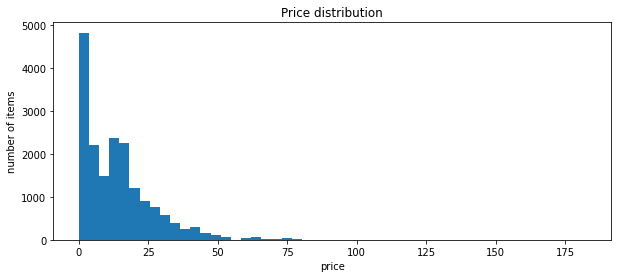

In [27]:
plt.figure(figsize=(10, 4))
plt.title('Price distribution')
plt.xlabel('price')
plt.ylabel('number of items')
plt.hist(data['price'].values, bins=50);

In [28]:
data['price'].describe()

count    18107.000000
mean        13.645690
std         13.638329
min          0.000000
25%          0.000000
50%         11.990000
75%         19.745000
max        182.480000
Name: price, dtype: float64

#### 2.4.1. Cheap items

In [29]:
lower_threshold = 0
cheap_products = data.loc[data['price'] <= lower_threshold, 'item_id'].unique().tolist()
len(cheap_products)

734

#### 2.4.2. Expensive items

In [30]:
upper_threshold = 50
expensive_products = data.loc[data['price'] > upper_threshold, 'item_id'].unique().tolist()
len(expensive_products)

56

### 2.5. User reviews

#### 2.5.1. Ratings

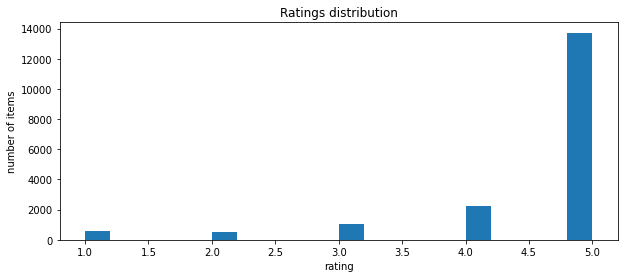

In [31]:
plt.figure(figsize=(10, 4))
plt.title('Ratings distribution')
plt.xlabel('rating')
plt.ylabel('number of items')
plt.hist(data['rating'].values, bins=20);

In [32]:
data['rating'].value_counts(normalize=True)

5.0    0.758160
4.0    0.123433
3.0    0.057492
1.0    0.033689
2.0    0.027227
Name: rating, dtype: float64

#### 2.5.2. Length of user reviews

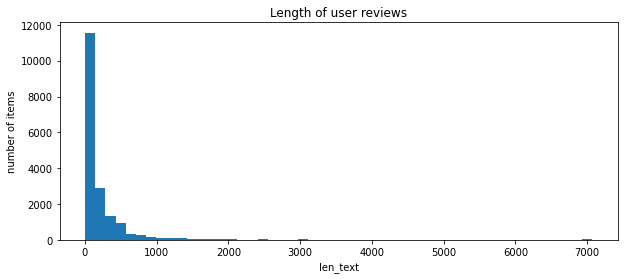

In [33]:
plt.figure(figsize=(10, 4))
plt.title('Length of user reviews')
plt.xlabel('len_text')
plt.ylabel('number of items')
plt.hist(data['len_text'].values, bins=50);

In [34]:
data['len_text'].describe()

count    18107.000000
mean       218.207710
std        477.208877
min          1.000000
25%         28.500000
50%         82.000000
75%        228.000000
max       7073.000000
Name: len_text, dtype: float64

In [35]:
(data['len_text'] == 1).sum()

3

### 2.6. Items matadata

#### 2.6.1. Feature 'also_view'

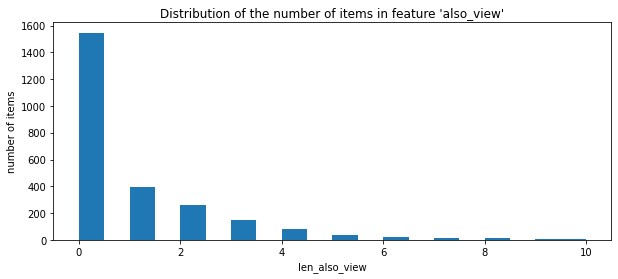

In [36]:
plt.figure(figsize=(10, 4))
plt.title("Distribution of the number of items in feature 'also_view'")
plt.xlabel('len_also_view')
plt.ylabel('number of items')
plt.hist(items['len_also_view'].values, bins=20);

In [37]:
items['len_also_view'].describe()

count    2529.000000
mean        0.919731
std         1.570685
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        10.000000
Name: len_also_view, dtype: float64

In [38]:
items.loc[items['len_also_view'] == 0, 'item_id'].nunique()

1546

#### 2.6.2. Feature  'also_buy'

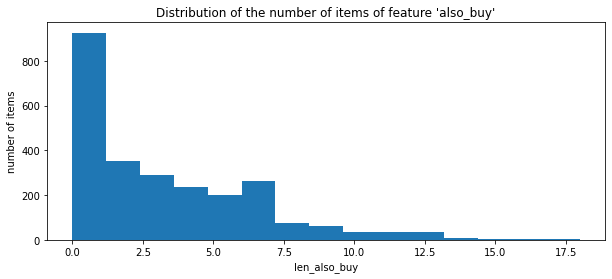

In [39]:
plt.figure(figsize=(10, 4))
plt.title("Distribution of the number of items of feature 'also_buy'")
plt.xlabel('len_also_buy')
plt.ylabel('number of items')
plt.hist(items['len_also_buy'].values, bins=15);

In [40]:
items['len_also_buy'].describe()

count    2529.000000
mean        3.245552
std         3.179401
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        18.000000
Name: len_also_buy, dtype: float64

In [41]:
items.loc[items['len_also_buy'] == 0, 'item_id'].nunique()

591

#### 2.6.3. Categories

In [42]:
feature = 'main_cat'
print(f"The number of unique categories: {items[feature].nunique()}\n")
items[feature].value_counts()

The number of unique categories: 8



Grocery                    2400
Health & Personal Care       89
Amazon Home                  22
Sports & Outdoors             5
Industrial & Scientific       3
All Beauty                    3
Office Products               2
                              1
Name: main_cat, dtype: int64

In [43]:
feature = 'category_1'
print(f"The number of unique categories: {items[feature].nunique()}\n")
items[feature].value_counts()

The number of unique categories: 24



Beverages                             731
Cooking & Baking                      391
Candy & Chocolate                     334
Snack Foods                           316
Breakfast Foods                       132
Herbs, Spices & Seasonings            112
Canned, Jarred & Packaged Foods        90
Soups, Stocks & Broths                 78
Jams, Jellies & Sweet Spreads          53
Sauces, Gravies & Marinades            43
Produce                                37
Dairy, Cheese & Eggs                   32
Pasta & Noodles                        29
Breads & Bakery                        28
Dried Beans, Grains & Rice             27
Condiments & Salad Dressings           26
Food & Beverage Gifts                  19
Olives, Pickles & Relishes             17
Meat & Seafood                         16
Frozen                                 10
Meat Substitutes                        3
Fresh Flowers & Live Indoor Plants      3
Deli                                    1
Prepared Foods                    

In [44]:
feature = 'category_2'
print(f"The number of unique categories: {items[feature].nunique()}\n")
items[feature].value_counts()

The number of unique categories: 145



Coffee, Tea & Cocoa                       539
Bottled Beverages, Water & Drink Mixes    189
Nuts & Seeds                               89
Cereals                                    75
Jelly Beans & Gummy Candy                  74
                                         ... 
Marmalades                                  1
Ice Cream Cones & Toppings                  1
Fruit                                       1
Lentils                                     1
Snack Gifts                                 1
Name: category_2, Length: 145, dtype: int64

In [45]:
feature = 'category_3'
print(f"The number of unique categories: {items[feature].nunique()}\n")
items[feature].value_counts()

The number of unique categories: 265



Coffee           270
Tea              247
Juices            46
Hard Candy        41
Oils              40
                ... 
Parmesan           1
Sweet Pickles      1
Wheat Berries      1
Curry Powder       1
Breakfast          1
Name: category_3, Length: 265, dtype: int64

#### 2.6.4. Brand

In [46]:
feature = 'brand'
print(f"The number of unique brands: {items[feature].nunique()}\n")
items[feature].value_counts()

The number of unique brands: 1273



Bob's Red Mill                    49
Campbell's                        26
Stash Tea                         25
McCormick                         23
Green Mountain Coffee Roasters    20
                                  ..
Amy & Brian                        1
Reily Foods                        1
Volcanica Coffee                   1
Duchy Originals                    1
Wild Soil                          1
Name: brand, Length: 1273, dtype: int64

#### 2.6.5. Ranking group

In [47]:
feature = 'rank_group'
print(f"The number of unique ranking groups: {items[feature].nunique()}\n")
items[feature].value_counts()

The number of unique ranking groups: 11



Grocery & Gourmet Food                                        2283
                                                               122
Health & Household                                              88
Kitchen & Dining (See Top 100 in Kitchen & Dining)              14
Sports & Outdoors                                               12
Beauty & Personal Care                                           3
Office Products                                                  2
Patio, Lawn & Garden (See Top 100 in Patio, Lawn & Garden)       2
Tools & Home Improvement                                         1
Iced Tea                                                         1
Industrial & Scientific                                          1
Name: rank_group, dtype: int64

#### 2.6.6. Item ranks

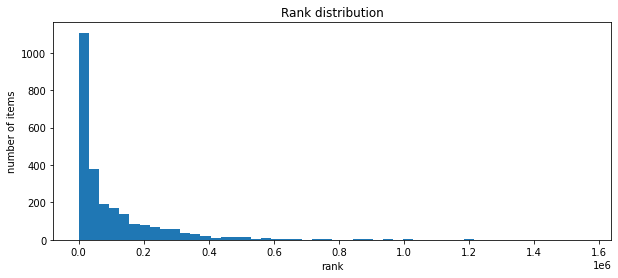

In [48]:
plt.figure(figsize=(10, 4))
plt.title('Rank distribution')
plt.xlabel('rank')
plt.ylabel('number of items')
plt.hist(items['rank'].values, bins=50);

In [49]:
items['rank'].describe()

count    2.529000e+03
mean     1.018681e+05
std      1.492155e+05
min      0.000000e+00
25%      9.778000e+03
50%      4.214700e+04
75%      1.356470e+05
max      1.559523e+06
Name: rank, dtype: float64

In [50]:
(items['rank'] == 0).sum()

122

## 3. Findings

1. Top popular items share less than 6.5% of unique users
2. There are 1157 top unpopular items with share of unique users of less than 0.06%
3. 125 items represet unpopular categories.
4. Mean price is 12. There are 734 items with no price information. Price of 56 items is higher than 50
5. More than 75% of ratings is 5 and only 6% is 1 or 2.
6. Mean length of user reviews is 82 characters, upper quartile starts from 228.
7. 1546 of items have no informmation about items also viewed. Upper quartile starts from 1 item with the maximum of 10.
8. 591 of items have no informmation about items also bought. Upper quartile starts from 5 item with the maximum of 18.
9. There are 8 main categories. Most of the items are in Grocery.
10. There are 24 sub-categories. Top sub-category is Beverages followed by Cooking & Baking, Candy & Chocolate, Snack Foods.
11. Top sub-caregory of the 2nd level (out of 145) is Coffee, Tea & Cocoa, 
12. Top sub-caregory of the 3d level (out of 265) is Coffee followeed by Tea.
13. The number of unique brands is 1273. The brand with the highest number of items is Bob's Red Mill.
14. There are 11 ranking groups, but most of the items belongs to Grocery & Gourmet Food 
15. 122 of items have no rank. Mean rank is 42147.